In [97]:
import argparse
from tqdm import tqdm
import json
import os
from torchmetrics.text import CharErrorRate, WordErrorRate
import jiwer

In [98]:
transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemovePunctuation(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
])

In [99]:


input_dir = "/home/efittsc1/projects/latin-transcription/work/max_data_-1/results"

train_results = input_dir + "/train"
val_results = input_dir + "/val"

results = {"train": [], "val": []}

for directory in [train_results, val_results]:
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r') as f:
            results[os.path.basename(directory)].append(json.load(f))






In [100]:
word_error_stats = {"train": {}, "val": {}}

In [101]:
for directory in results.keys():
    for i in tqdm(range(len(results[directory]))):
        reference = transformation(results[directory][i]["truth"])
        hypothesis = transformation(results[directory][i]["prediction"])
        truth_words = reference.split(" ")
        comparison = jiwer.process_words(reference, hypothesis)
        for alignment in comparison.alignments[0]:
            for index in range(alignment.ref_start_idx, alignment.ref_end_idx):
                word_ = truth_words[index]
                type_ = alignment.type
                if word_ not in word_error_stats[directory]:
                    word_error_stats[directory][word_] = {}
                if type_ not in word_error_stats[directory][word_]:
                    word_error_stats[directory][word_][type_] = 0
                if "total" not in word_error_stats[directory][word_]:
                    word_error_stats[directory][word_]["total"] = 0
                word_error_stats[directory][word_][type_] += 1
                word_error_stats[directory][word_]["total"] += 1

                


100%|██████████| 233/233 [00:00<00:00, 10526.76it/s]


In [102]:
val_words = set(word_error_stats["val"].keys())
train_words = set(word_error_stats["train"].keys())

print(f"train len: {len(train_words)}")
print(f"val len: {len(val_words)}")

val_not_in_train = val_words - train_words

print(f"val not in train: {len(val_not_in_train)}")
print(val_not_in_train)

train len: 4503
val len: 1331
val not in train: 237
{'proprie', 'pimmel', 'ho', 'norhtforyate', 'andegavie', 'normannie', 'firmacula', 'brimes', 'tholthorp', 'manuagii', 'declopton', 'hesinhull', 'vastatis', 'vaccas', 'mathie', 'furata', 'liberatas', 'assheburn', 'convincendum', 'precio', 'pretensam', 'valeat', 'nater', 'defectum', 'tare', 'tre', 'jocalia', 'comodum', 'uxoris', 'percipiendam', 'tulerunt', 'auxilio', 'continue', 'constitucionem', 'symonis', 'aliter', 'dicari', 'cecilia', 'alij', 'albus', 'sequebatur', 'existencium', 'cornubie', 'fraude', 'aueria', 'bonis', 'caloch', 'molere', 'lunar', 'attornatos', 'xilij', 'hybernie', 'pyrie', 'easdem', 'judicii', 'prisonum', 'aldemare', 'redem', 'sores', 'xxmo', 'magis', 'clamavit', 'removendum', 'assignatas', 'ligauit', 'chyrin', 'admisit', 'na', 'licit', 'wemme', 'mor', 'tokene', 'custos', 'ta', 'xori', 'execucione', 'emit', 'wolveseye', 'totus', 'cura', 'utilitatem', 'waut', 'duxit', 'contemptu', 'hundretorum', 'godefridi', 'medita

In [103]:
def calculate_accuracy(list_word_stats):
    total = 0
    correct = 0
    for word, stats in list_word_stats:
        total += stats["total"]
        correct += stats["equal"] if "equal" in stats else 0
    return correct / total

In [104]:
train_accuracy = calculate_accuracy(list(word_error_stats["train"].items()))
val_accuracy = calculate_accuracy(list(word_error_stats["val"].items()))

print(f"train accuracy: {train_accuracy}")
print(f"val accuracy: {val_accuracy}")

train accuracy: 0.9419863991268576
val accuracy: 0.8815888083937047


In [105]:
words_not_in_train_accuracy = calculate_accuracy([(word, word_error_stats["val"][word]) for word in val_not_in_train])
print(f"words not in train accuracy: {words_not_in_train_accuracy}")

words not in train accuracy: 0.4583333333333333


In [106]:
import pandas as pd

val_df = pd.DataFrame.from_dict(word_error_stats["val"], orient='index')
train_df = pd.DataFrame.from_dict(word_error_stats["train"], orient='index')

val_not_in_train_df = pd.DataFrame.from_dict({word: word_error_stats["val"][word] for word in val_not_in_train}, orient='index')


val_df["accuracy"] = val_df["equal"] / val_df["total"]
train_df["accuracy"] = train_df["equal"] / train_df["total"]
val_not_in_train_df["accuracy"] = val_not_in_train_df["equal"] / val_not_in_train_df["total"]

In [109]:
total_errors_train = train_df["substitute"].sum() + train_df["delete"].sum()
total_errors_val = val_df["substitute"].sum() + val_df["delete"].sum()
total_errors_val_not_in_train = val_not_in_train_df["substitute"].sum() + val_not_in_train_df["delete"].sum()

In [111]:
print(f"total errors train: {total_errors_train}")
print(f"total errors val: {total_errors_val}")
print(f"total errors val not in train: {total_errors_val_not_in_train}")

total errors train: 2073.0
total errors val: 474.0
total errors val not in train: 130.0


In [112]:
total_errors_val_not_in_train/total_errors_val

np.float64(0.2742616033755274)

In [ ]:
train_df.head()

,equal,total,substitute,delete,accuracy
et,2479.0,2593,50.0,64.0,0.956035
in,848.0,863,8.0,7.0,0.982619
quas,16.0,16,NaN,NaN,1.000000
iidem,9.0,9,NaN,NaN,1.000000
thomas,95.0,102,6.0,1.0,0.931373


In [ ]:
# levenstein distance
import Levenshtein

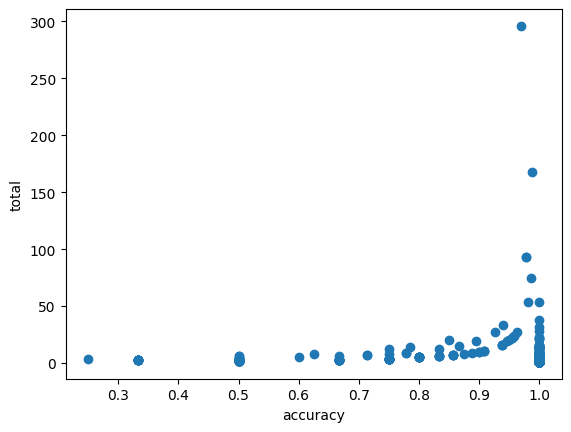

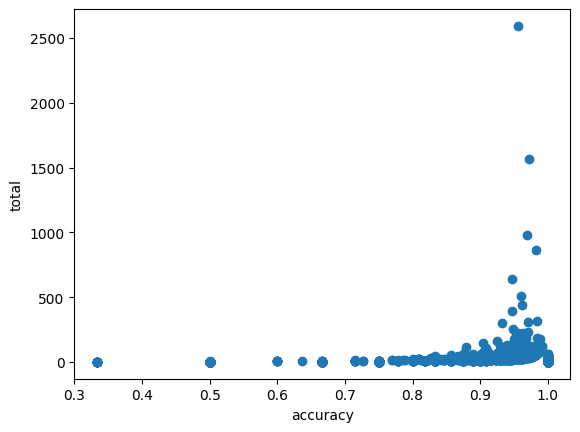

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(val_df["accuracy"], val_df["total"])
plt.xlabel("accuracy")
plt.ylabel("total")
plt.show()

plt.scatter(train_df["accuracy"], train_df["total"])
plt.xlabel("accuracy")
plt.ylabel("total")
plt.show()

In [ ]:
import numpy as np
import math

In [ ]:
distance_mapping = {}
for word in val_not_in_train:
    # find the closest word in train
    distances = {train_word: Levenshtein.distance(word, train_word) for train_word in train_words}
    closest_word = min(distances, key=distances.get)
    closest_distance = distances[closest_word]
    if closest_distance not in distance_mapping:
        distance_mapping[closest_distance] = {"total": 0, "correct": 0}
    distance_mapping[closest_distance]["total"] += val_not_in_train_df.loc[word]["total"].item()
    equal = val_not_in_train_df.loc[word]["equal"].item()
    if not math.isnan(equal):
        distance_mapping[closest_distance]["correct"] += equal




In [ ]:
distance_mapping

{1: {'total': 115.0, 'correct': 55.0},
 6: {'total': 3.0, 'correct': 1.0},
 4: {'total': 16.0, 'correct': 4.0},
 2: {'total': 61.0, 'correct': 28.0},
 3: {'total': 38.0, 'correct': 20.0},
 5: {'total': 6.0, 'correct': 2.0},
 7: {'total': 1.0, 'correct': 0}}

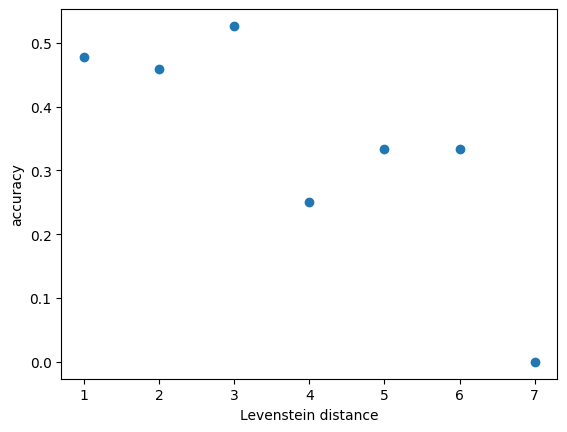

In [ ]:
word_distances = list(distance_mapping.keys())
word_accuracies = [distance_mapping[distance]["correct"] / distance_mapping[distance]["total"] for distance in word_distances]
# plot levenstein distance on x axis and the accuracy on y axis
plt.scatter(word_distances, word_accuracies)
plt.xlabel("Levenstein distance")
plt.ylabel("accuracy")
plt.show()